<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [65]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
#pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime

In [11]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [12]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as f:
        countdict = pickle.load(f)
    
    files = glob(os.path.join(path_to_csv_files, 'user????.csv'))
    lOut = []

    for fname in files:
        user_id = int(fname[-8:-4])
        l, t = [], []
        with open(fname) as f:                        
            for line in [line.rstrip() for line in f][1:]:
                atmp = line.split(',')
                l.append(countdict[atmp[1]][0])
                t.append(datetime.strptime(atmp[0], "%Y-%m-%d %H:%M:%S"))
                
        numses = (len(l)//window_size)
        if numses*window_size == len(l): numses-=1
        nadd = ((numses * window_size + session_length) - len(l))# %session_length
        if nadd != 0: l += list(np.zeros(nadd, dtype=np.int))
         
        lenmax = len(l)
        for i in np.arange(0, numses+1, dtype=np.int):
            ldattmp = t[i*window_size: min(i*window_size + session_length, lenmax)]
            dmin = min(ldattmp)
            ltmp = l[i*window_size: min(i*window_size + session_length, lenmax)]
            lOut += [ ltmp +  [ 0, 0, 0, 0, 0, 0, 0, 0, 0] + 
                     [(max(ldattmp) - dmin).total_seconds(), 
                      len(set(ltmp).difference([0])), 
                      dmin.hour, dmin.weekday(), user_id] ]
              
    
    dfOut = pd.DataFrame( lOut, columns= feature_names, dtype=np.int)
    
    return dfOut

**Проверим функцию на игрушечном примере.**

In [13]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
#print(feature_names)
train_data_toy_0  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [14]:
#train_data_toy_0[['session_timespan', '#unique_sites', 
#                                            'start_hour', 'day_of_week']].values
train_data_toy_0

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,4,2,2,9,2,1,7,6,8,10,0,0,0,0,0,0,0,0,0,7998,8,9,4,1
1,4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,2,12,4,1
2,4,2,5,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7935,3,9,4,2
3,3,1,2,1,2,1,1,6,11,3,0,0,0,0,0,0,0,0,0,7998,5,9,4,3
4,3,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1471,3,12,4,3


In [15]:
#train_data_toy

**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [16]:
%%time
train_data_10users =  prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 2.57 s


In [17]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,577,134,3,134,134,3,134,203,134,0,0,0,0,0,0,0,0,0,33,5,8,4,31
1,425,193,687,254,134,31,394,3841,218,55,0,0,0,0,0,0,0,0,0,284,10,8,4,31
2,55,3,55,55,5,293,425,340,908,55,0,0,0,0,0,0,0,0,0,258,7,8,4,31
3,473,4015,473,55,55,55,55,980,201,123,0,0,0,0,0,0,0,0,0,30,6,8,4,31
4,348,55,5,3837,258,212,3937,2157,676,2157,0,0,0,0,0,0,0,0,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [18]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 20.5 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [19]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 
                                            'start_hour', 'day_of_week']].values
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 
                                            'start_hour', 'day_of_week']].values

In [20]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [21]:
#train_data_10users.groupby('target')[['session_timespan']].median()
train_data_10users.session_timespan.median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [22]:
#train_data_10users.groupby('target')[['day_of_week']].median()
train_data_10users.day_of_week.median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [23]:
#train_data_150users.groupby('target')[['start_hour']].median()
train_data_150users.start_hour.median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [24]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [25]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [26]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

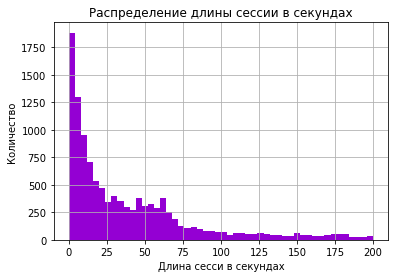

In [27]:
plt.hist(train_data_10users['session_timespan'].values, 50, 
         range=[0, 200],  facecolor='darkviolet')

plt.xlabel('Длина сесси в секундах')
plt.ylabel('Количество')
plt.title('Распределение длины сессии в секундах')
## plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()
  

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

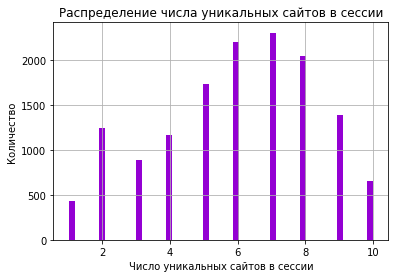

In [28]:
plt.hist(train_data_10users['#unique_sites'].values, 50, 
           facecolor='darkviolet')

plt.xlabel('Число уникальных сайтов в сессии')
plt.ylabel('Количество')
plt.title('Распределение числа уникальных сайтов в сессии')
## plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

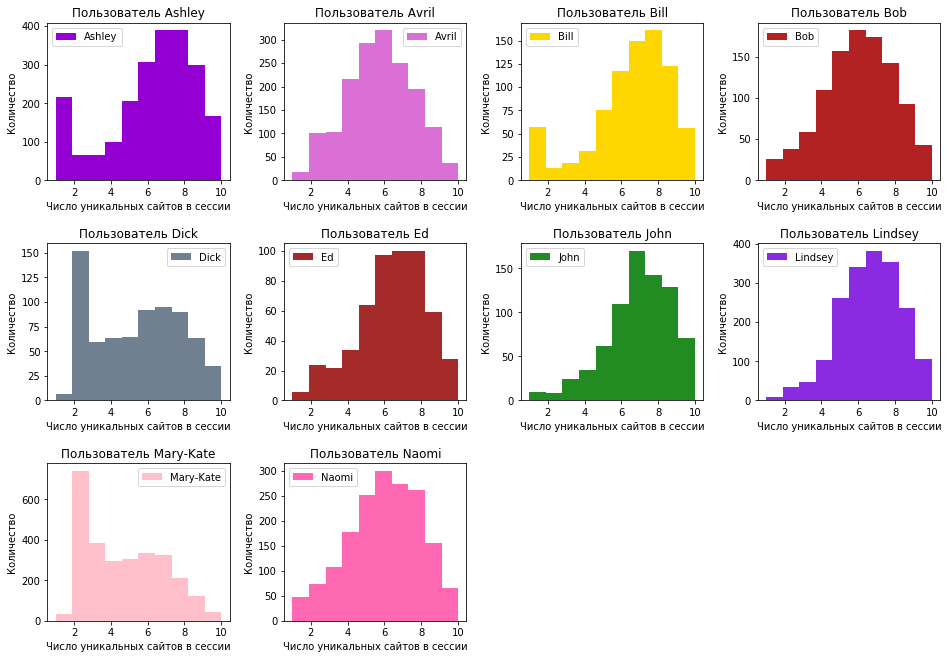

In [29]:

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 11),)
plt.subplots_adjust( wspace=.3, hspace=.4)
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')['#unique_sites']):
    subplot = axes[idx//4, idx%4]
    subplot.hist(sub_df, facecolor=color_dic[user])
    subplot.legend((user, ))
    subplot.title.set_text('Пользователь {}'.format(user))
    subplot.yaxis.label.set_text('Количество')
    subplot.xaxis.label.set_text('Число уникальных сайтов в сессии')


for i in range(idx+1, 3*4):
    fig.delaxes(axes[i//4, i%4])

plt.show()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

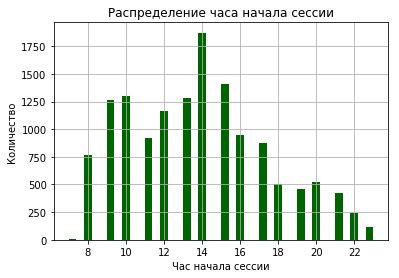

In [30]:
plt.hist(train_data_10users['start_hour'].values, 40,
           facecolor='darkgreen')

plt.xlabel('Час начала сессии')
plt.ylabel('Количество')
plt.title('Распределение часа начала сессии')
## plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

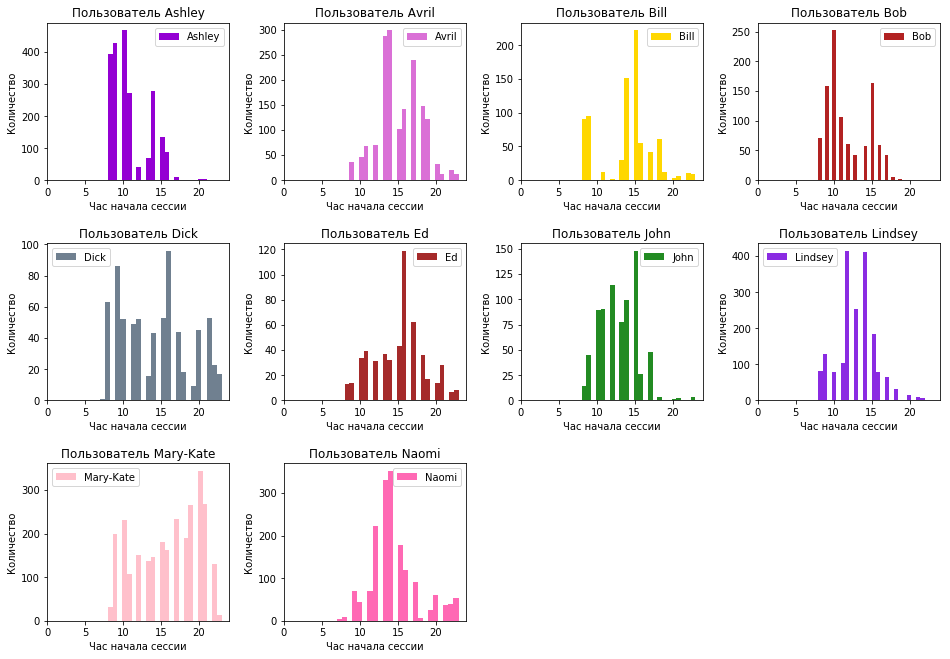

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 11),)
plt.subplots_adjust( wspace=.3, hspace=.4)
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')['start_hour']):
    subplot = axes[idx//4, idx%4]
    subplot.hist(sub_df, 24, facecolor=color_dic[user])
    subplot.legend((user, ))
    subplot.title.set_text('Пользователь {}'.format(user))
    subplot.yaxis.label.set_text('Количество')
    subplot.xaxis.label.set_text('Час начала сессии')
    subplot.set_xlim([0, 24])

for i in range(idx+1, 3*4):
    fig.delaxes(axes[i//4, i%4])

plt.show()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

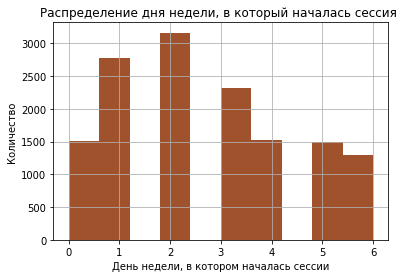

In [32]:
plt.hist(train_data_10users['day_of_week'].values, 
           facecolor='sienna')

plt.xlabel('День недели, в котором началась сессии')
plt.ylabel('Количество')
plt.title('Распределение дня недели, в который началась сессия ')
## plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

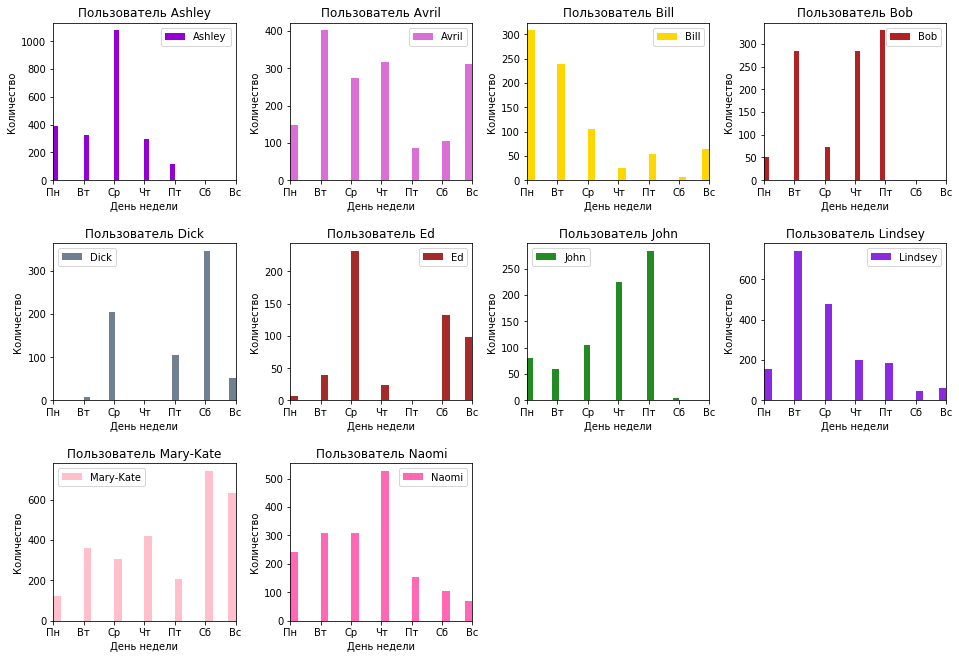

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 11),)
plt.subplots_adjust( wspace=.3, hspace=.4)
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')['day_of_week']):
    subplot = axes[idx//4, idx%4]
    subplot.hist(sub_df, 24, facecolor=color_dic[user])
    subplot.legend((user, ))
    subplot.title.set_text('Пользователь {}'.format(user))
    subplot.yaxis.label.set_text('Количество')
    subplot.xaxis.label.set_text('День недели')
    subplot.set_xlim([0, 6])
    subplot.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

for i in range(idx+1, 3*4):
    fig.delaxes(axes[i//4, i%4])

plt.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [34]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    countdict = pickle.load(f)


**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [35]:
top10_sites = list(countdict)[:10]
top10_freqs = [ countdict[k][1] for k in  top10_sites]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

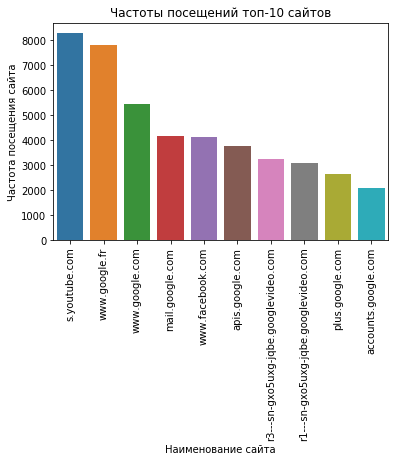

In [36]:
plt.figure()
plt.title('Частоты посещений топ-10 сайтов')
ax = sns.barplot(top10_sites, top10_freqs)
ax.set(xlabel="Наименование сайта", ylabel='Частота посещения сайта')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [118]:
def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10):
    window_size = session_length
    with open(site_freq_path, 'rb') as f:
        countdict = pickle.load(f)
    
    # делим сутки так: ночь с 0 до 8 часов, утро с 8 до 11 часов, 
    # день с 11 до 18 часов, вечер с 18 до 00.
    # данные ориентированы на Википедию.
    l_day_quarte = [range(0, 8), range(8, 11), range(11, 18), range(18, 24)]
    
    #строим список из id сайтов, в которых есть подстрока facebook
    l_facebook_id = [ countdict[s][0] for s in  list(countdict) if 'facebook' in s]
    
    #строим список из id сайтов, из top-30
    l_top30_sites_id = set([ countdict[s][0] for s in  list(countdict)[:30]])
    
    files = glob(os.path.join(path_to_csv_files, 'user????.csv'))
    lOut = []

    for fname in files:
        user_id = int(fname[-8:-4])
        l, t = [], []
        with open(fname) as f:                        
            for line in [line.rstrip() for line in f][1:]:
                atmp = line.split(',')
                l.append(countdict[atmp[1]][0])
                t.append(datetime.strptime(atmp[0], "%Y-%m-%d %H:%M:%S"))
                
        numses = (len(l)//window_size)
        if numses*window_size == len(l): numses-=1
        nadd = ((numses * window_size + session_length) - len(l))# %session_length
        if nadd != 0: l += list(np.zeros(nadd, dtype=np.int))
         
        lenmax = len(l)
        for i in np.arange(0, numses+1, dtype=np.int):
            ldattmp = t[i*window_size: min(i*window_size + session_length, lenmax)]
            dmin = min(ldattmp)
            ltmp = l[i*window_size: min(i*window_size + session_length, lenmax)]
            countFacebook = sum([1 if i in l_facebook_id else 0 for i in ltmp ])
            isTop30 = int(len(l_top30_sites_id & set(ltmp) ) > 0)      
            dayQuarte = [ i for i, r in enumerate(l_day_quarte) if dmin.hour in r][0]  
            lOut += [ ltmp +  [ 0, 0, 0, 0, 0, 0, 0, 0, 0] + 
                     [(max(ldattmp) - dmin).total_seconds(), 
                      len(set(ltmp).difference([0])), 
                      dmin.hour, dmin.weekday(), 
                      dayQuarte, isTop30,
                      countFacebook,  user_id] ]
              
    dfOut = pd.DataFrame( lOut, columns= features, dtype=np.int)
    return dfOut


In [119]:
#[1 for i in [1, 2, 3, 4, 5, 6] if countdict[i]
#[ countdict[s][0] for s in  list(countdict.keys()) if 'facebook' in s]



new_feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'dayQuarte', 'isTop30', 'countFacebook', 'target']

new_train_data_10users =  feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  features=new_feature_names, session_length=10)

In [117]:
l_day_quarte = [range(0, 8), range(8, 11), range(11, 18), range(18, 24)]
h = 8
[ i for i, r in enumerate(l_day_quarte) if h in r][0]

1

In [121]:
new_train_data_10users[new_train_data_10users.isTop30 != 0].head(30)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,dayQuarte,isTop30,countFacebook,target
0,192,577,134,3,134,134,3,134,203,134,0,0,...,0,0,0,0,33,5,8,4,1,1,0,31
2,55,3,55,55,5,293,425,340,908,55,0,0,...,0,0,0,0,258,7,8,4,1,1,1,31
4,348,55,5,3837,258,212,3937,2157,676,2157,0,0,...,0,0,0,0,6,9,8,4,1,1,1,31
6,350,577,134,3,134,31,134,394,192,134,0,0,...,0,0,0,0,347114,7,8,4,1,1,0,31
7,262,4007,1696,394,55,3,55,3,201,123,0,0,...,0,0,0,0,28,8,9,1,1,1,0,31
8,55,340,106,203,1280,515,55,813,106,5,0,0,...,0,0,0,0,2,8,9,1,1,1,1,31
10,613,174,174,464,2,2,6,3,2,2823,0,0,...,0,0,0,0,13523,7,9,1,1,1,0,31
11,2823,4338,4158,2253,162,162,118,90,2,90,0,0,...,0,0,0,0,31,8,12,1,2,1,0,31
12,108,565,617,18,44,108,391,17,90,2374,0,0,...,0,0,0,0,2,9,12,1,2,1,3,31
13,90,754,5,102,22,1294,1294,90,565,31,0,0,...,0,0,0,0,10,8,12,1,2,1,1,31


In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 